In [32]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [55]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 345

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

In [34]:
# Load data
images = np.load("Data/sample_1000_image.npy")
labels = np.load("Data/sample_1000_label.npy")

# Normalize image data.  0-255 to 0-1
images = images / 255
df = pd.DataFrame(np.concatenate((images, labels), axis=1))

# Rename the last column as "label"
df.rename(columns={784:"label"}, inplace=True)

# Convert label column to integer type
df['label'] = df['label'].astype('int64')

In [35]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [36]:
# Get "img" data frame and "lbl" series from the df
img = df.iloc[:, 0:-1]
lbl = df['label']
# Split into train, validation and test set
x_train1, x_test, y_train1, y_test = train_test_split(img, lbl, test_size = 0.20, random_state = 123, stratify = lbl)
x_train, x_valid, y_train, y_valid = train_test_split(x_train1, y_train1, test_size = 0.2, random_state = 123, stratify = y_train1)

In [37]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(220800, 784)
(55200, 784)
(69000, 784)
(220800,)
(55200,)
(69000,)


In [38]:
# Convert dataframe to tensor
x_train = torch.tensor(x_train.values)
y_train = torch.tensor(y_train.values)

x_valid = torch.tensor(x_valid.values)
y_valid = torch.tensor(y_valid.values)

x_test = torch.tensor(x_test.values)
y_test = torch.tensor(y_test.values)

In [39]:
# Reshape all tensors to the size of (length, 1, 28, 28)
x_train = x_train.reshape((-1, 1, 28, 28))
x_valid = x_valid.reshape((-1, 1, 28, 28))
x_test = x_test.reshape((-1, 1, 28, 28))

In [40]:
# Create dataloaders

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=4)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=4)

In [41]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [42]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [43]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [56]:
torch.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [57]:
DEVICE

'cuda:0'

In [46]:
def print_sizes(self, input, output):

    print('Inside ' + self.__class__.__name__ + ' forward')
    print('input size:', input[0].size())
    print('output size:', output.data.size())

    
## Debugging


# model.features[0].register_forward_hook(print_sizes)
# model.features[1].register_forward_hook(print_sizes)
# model.features[2].register_forward_hook(print_sizes)
# model.features[3].register_forward_hook(print_sizes)

# model.classifier[0].register_forward_hook(print_sizes)
# model.classifier[1].register_forward_hook(print_sizes)
# model.classifier[2].register_forward_hook(print_sizes)


In [47]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
        
        features = features.float()
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [48]:
list_costs = []

In [49]:
list_epochs = np.linspace(0, 9.75, num=40)
list_epochs

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ,
       8.25, 8.5 , 8.75, 9.  , 9.25, 9.5 , 9.75])

In [58]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.float()
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
            list_costs.append(cost)


    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE) ))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/1725 | Cost: 6.2603
Epoch: 001/010 | Batch 0500/1725 | Cost: 3.3871
Epoch: 001/010 | Batch 1000/1725 | Cost: 2.6531
Epoch: 001/010 | Batch 1500/1725 | Cost: 2.6199
Epoch: 001/010 | Train: 43.077% | Validation: 41.558%
Time elapsed: 3.58 min
Epoch: 002/010 | Batch 0000/1725 | Cost: 2.2290
Epoch: 002/010 | Batch 0500/1725 | Cost: 2.1733
Epoch: 002/010 | Batch 1000/1725 | Cost: 2.1312
Epoch: 002/010 | Batch 1500/1725 | Cost: 1.7789
Epoch: 002/010 | Train: 53.250% | Validation: 49.788%
Time elapsed: 7.24 min
Epoch: 003/010 | Batch 0000/1725 | Cost: 2.2438
Epoch: 003/010 | Batch 0500/1725 | Cost: 1.9440
Epoch: 003/010 | Batch 1000/1725 | Cost: 1.6455
Epoch: 003/010 | Batch 1500/1725 | Cost: 1.7840
Epoch: 003/010 | Train: 57.961% | Validation: 53.674%
Time elapsed: 11.09 min
Epoch: 004/010 | Batch 0000/1725 | Cost: 1.8075
Epoch: 004/010 | Batch 0500/1725 | Cost: 1.4772
Epoch: 004/010 | Batch 1000/1725 | Cost: 1.6899
Epoch: 004/010 | Batch 1500/1725 | Cost: 1.2711


In [51]:
# Accuracy after 10 epochs, lr=0.005
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 58.18%


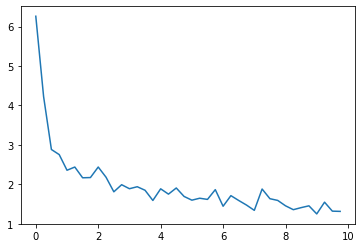

In [52]:
plt.plot(list_epochs, list_costs)

In [53]:
# For lr = 0.005
list_costs_1 = list_costs
list_costs = []

In [54]:
del(model)

In [ ]:
list_costs_2 = list_costs
list_costs = []

In [59]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 59.87%


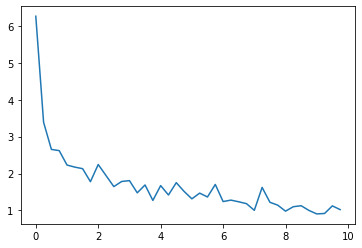

In [60]:
plt.plot(list_epochs, list_costs)

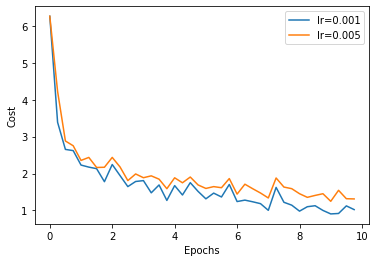

In [61]:
plt.plot(list_epochs, list_costs, label='lr=0.001')
plt.plot(list_epochs, list_costs_1, label='lr=0.005')
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend(loc='upper right')
plt.savefig("ResNet-34.pdf")
plt.savefig("ResNet-34.png")